# 1. Busca arboles de decision adecuados para los datos de pinguinos (considerando las 3 familias, sin considerar la isla). Discute los resultados.

Compara los resultados con K-NN.

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier


!pip install palmerpenguins

from palmerpenguins import load_penguins

Defaulting to user installation because normal site-packages is not writeable


In [5]:
penguins = load_penguins()
penguins.drop('island', axis=1, inplace=True)
penguins.dropna(inplace=True)
penguins['sex'] = penguins['sex'].map({'male': 0, 'female': 1})
penguins.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,39.1,18.7,181.0,3750.0,0,2007
1,Adelie,39.5,17.4,186.0,3800.0,1,2007
2,Adelie,40.3,18.0,195.0,3250.0,1,2007
4,Adelie,36.7,19.3,193.0,3450.0,1,2007
5,Adelie,39.3,20.6,190.0,3650.0,0,2007


In [6]:
X = penguins.drop('species', axis=1)
y = penguins['species']

Generacion de indices para validacion cruzada y listas con scores para arboles de decision y KNN

In [7]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

ccp_alphas = np.linspace(0, 0.05, 20) # rango de valores para ccp_alpha
clfs_scores = np.zeros(len(ccp_alphas))

knn_scores = np.zeros(20)
rg = range(1,21) # rango de numero de vecinos

Cross validation para los diferentes modelos de arbol de decision y knn entrenados

In [32]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # arboles de decision
    for i in range(len(ccp_alphas)):
        clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alphas[i])
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        clfs_scores[i] += f1_score(y_test, y_pred, average='weighted')
    
    for i in rg:
        neigh = KNeighborsClassifier(n_neighbors=i)
        neigh.fit(X_train, y_train)
        y_pred=neigh.predict(X_test)
        knn_scores[i-1] += f1_score(y_test, y_pred, average='weighted')

clfs_scores /= kf.get_n_splits()
knn_scores /= kf.get_n_splits()

/home/juancho/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/juancho/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/juancho/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/juancho/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

Text(0.5, 1.0, 'KNN')

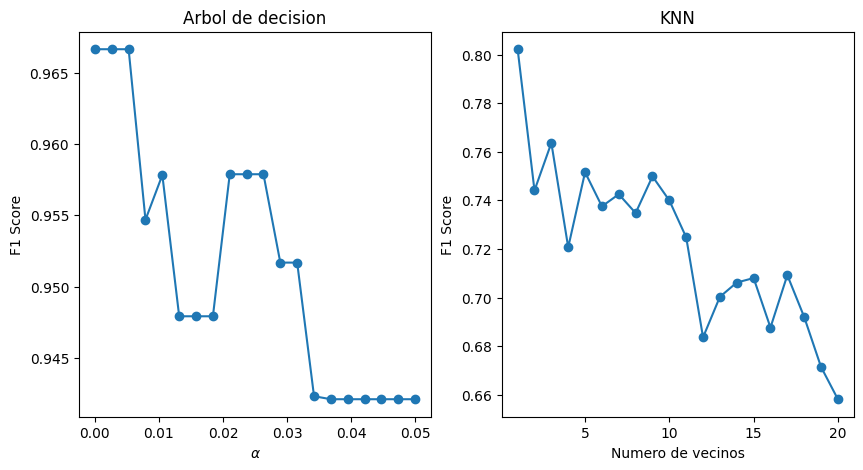

In [33]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(ccp_alphas, clfs_scores, marker='o')
plt.xlabel(r'$\alpha$')
plt.ylabel('F1 Score')
plt.title('Arbol de decision')

plt.subplot(1, 2, 2)
plt.plot(rg, knn_scores, marker='o')
plt.xlabel('Numero de vecinos')
plt.ylabel('F1 Score')
plt.title('KNN')

Hecho el cross validation, se observa que el arbol de decision para valores de $\alpha$ muy cercanos a 0 obtiene un valor de F1 notablemente mayor al mejor modelo de KNN (con $k=2$), posiblemente debido a que existen separaciones mas distinguibles para variables en particular (lo que beneficia al arbol de decision), mientras que al considerar todas las variables las separaciones son menos notables (perjudicando a KNN); esto resulta evidente al graficar pares de variables por separado, donde se observan algunas (como bill_length y bill_depth) donde las tres especies muestran separaciones claras.

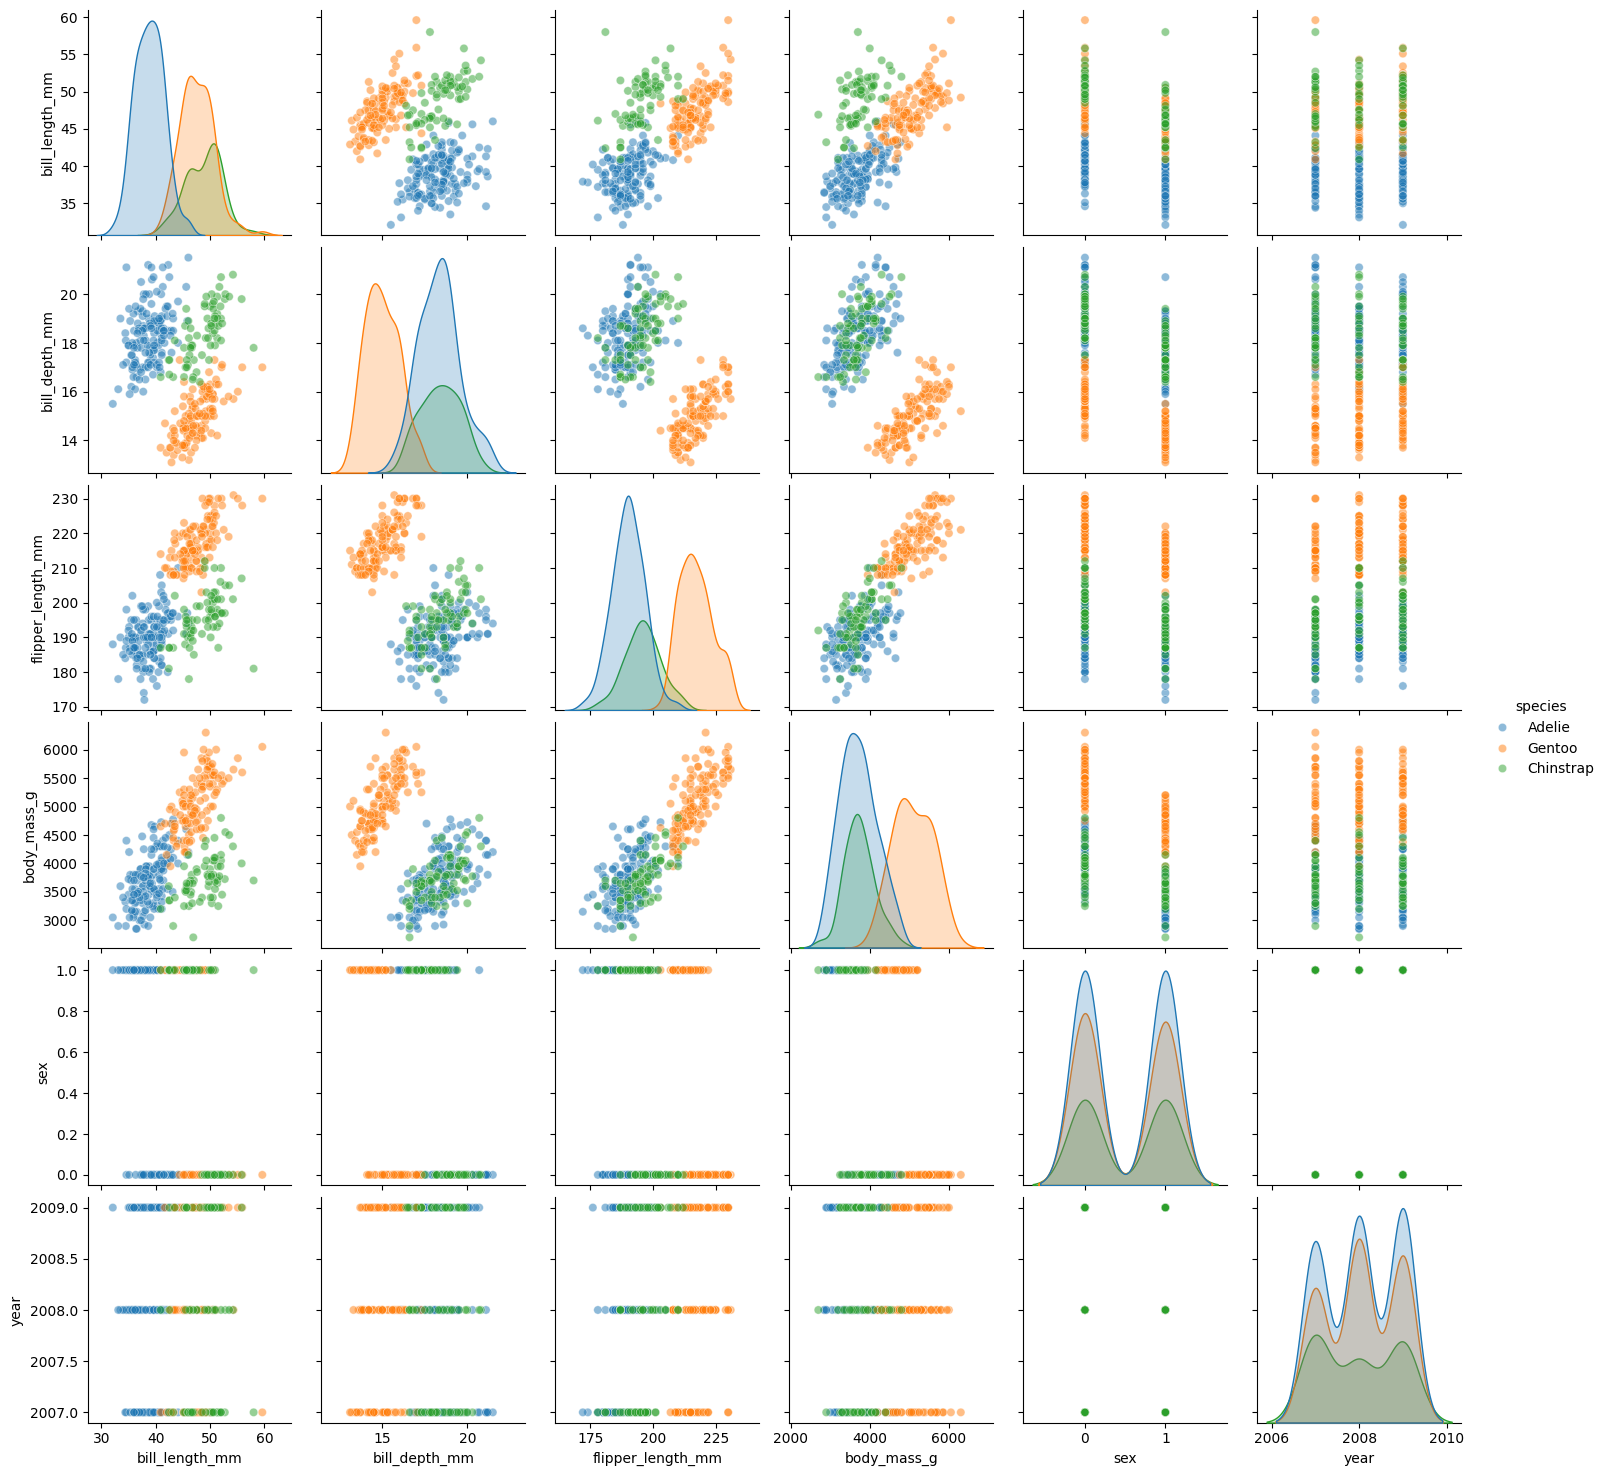

In [34]:
sns.pairplot(penguins, diag_kind='kde', plot_kws={'alpha':0.5},hue='species')

2. El clasificador ingenuo Bayesiano consiste en suponer que X|Y = y tiene componentes independientes, es decir: $P(X = x|Y = y) = \prod_i P(X_i =x_i|Y = y)$. Tiene la ventajas que ya no se debe estimar una distribucion multivariada, sino (muchas) univariadas.

Ajuste clasificadores ingenuos Bayesianos a los datos de los pinguinos
suponiendo que $P(X_i = x_i|Y = y)$ son distribuciones univariadas normales. No se puede usar una libreria que calcula el ingenuo Bayesiano; habra que hacerlo desde cero.

In [15]:
def normal_pdf(x, mean, std):
    ''''
    Funcion de densidad de probabilidad de una normal
    '''
    return 1 / (std * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

Usando $$P(Y=y|X=x)=\frac{P(X=x|Y=y)\cdot P(Y=y)}{P(X=x)}$$
Dado que $P(X=x)$ es igual para todas las clases, se omite en el calculo.

Asimismo, dado que la probabilidad de una variable aleatoria continua en un punto en particular es cero, se aprovecha el hecho de que $$P(x-\epsilon\leq X \leq x+\epsilon)\approx f(x)$$
para $\epsilon$ pequena, y con $f(x)$ la funcion de densidad de probabilidad de $X$.

In [ ]:
def prob_y_given_X(y, X, params):
    '''
    Calcula la probabilidad de que la muestra X pertenezca a la clase y
    considerando que X|Y=y tiene componentes independientes con distribucion normal.
    '''
    p = np.log(normal_pdf(X, params[y]['mean'], params[y]['std'])).sum()
    return p+np.log(params[y]['p'])

In [23]:
def naive_bayes_predict(X, params):
    '''
    Predice la clase de la muestra X considerando el modelo de Bayes ingenuo.
    '''
    p = {}
    for species in params.keys():
        p[species] = prob_y_given_X(species, X, params)
    return max(p, key=p.get)

## Cross validation sobre el modelo

In [42]:
import warnings
warnings.filterwarnings('ignore')

f1s = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    params = {}
    for species in penguins['species'].unique():
        params[species] = {
            'mean': X_train[y_train == species].mean(),
            'std': X_train[y_train == species].std(),
            'p': y_train[y_train == species].shape[0] / y_train.shape[0]
        }
    
    y_pred = X_test.apply(lambda x: naive_bayes_predict(x, params), axis=1)
    f1s.append(f1_score(y_test, y_pred, average='weighted'))

print("F1 score: ", sum(f1s)/kf.get_n_splits())

F1 score:  0.26845339095529697
